In [22]:
import mysql.connector
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

# 连接到数据库
db = mysql.connector.connect(
    host="localhost",
    port="3366",
    user="root",
    password="123456",
    database="stackexchange_cs"
)


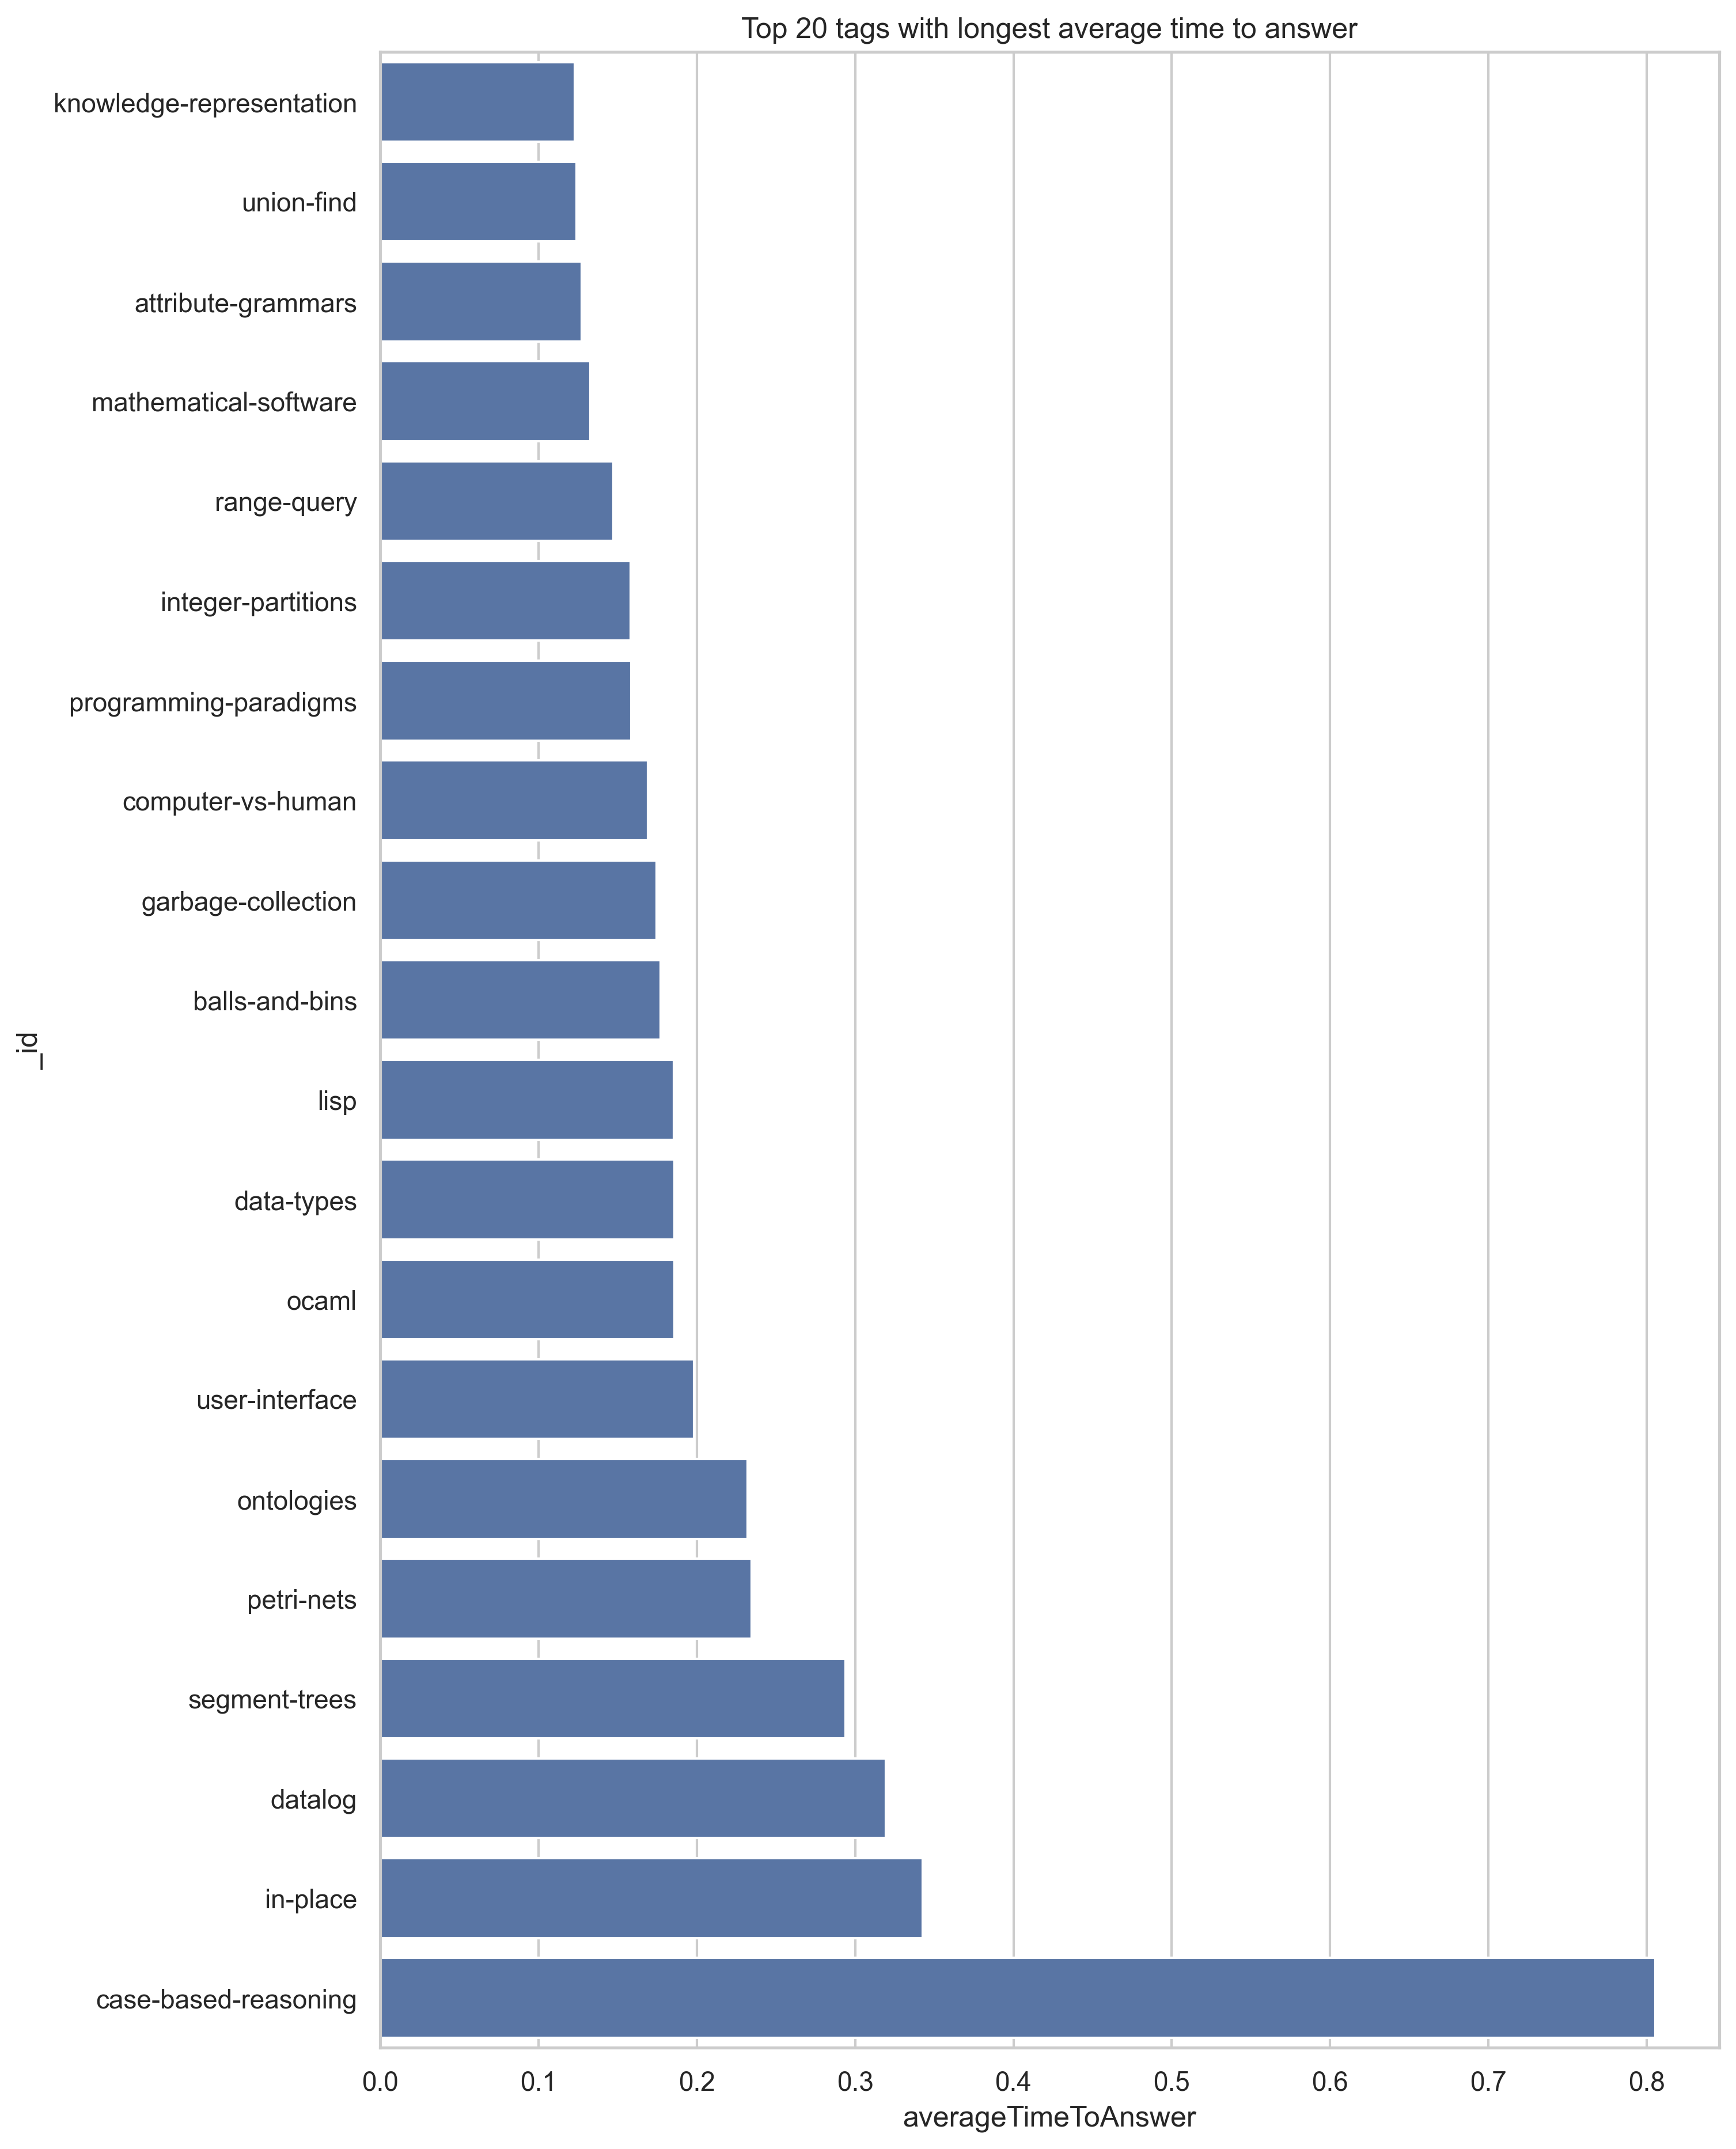

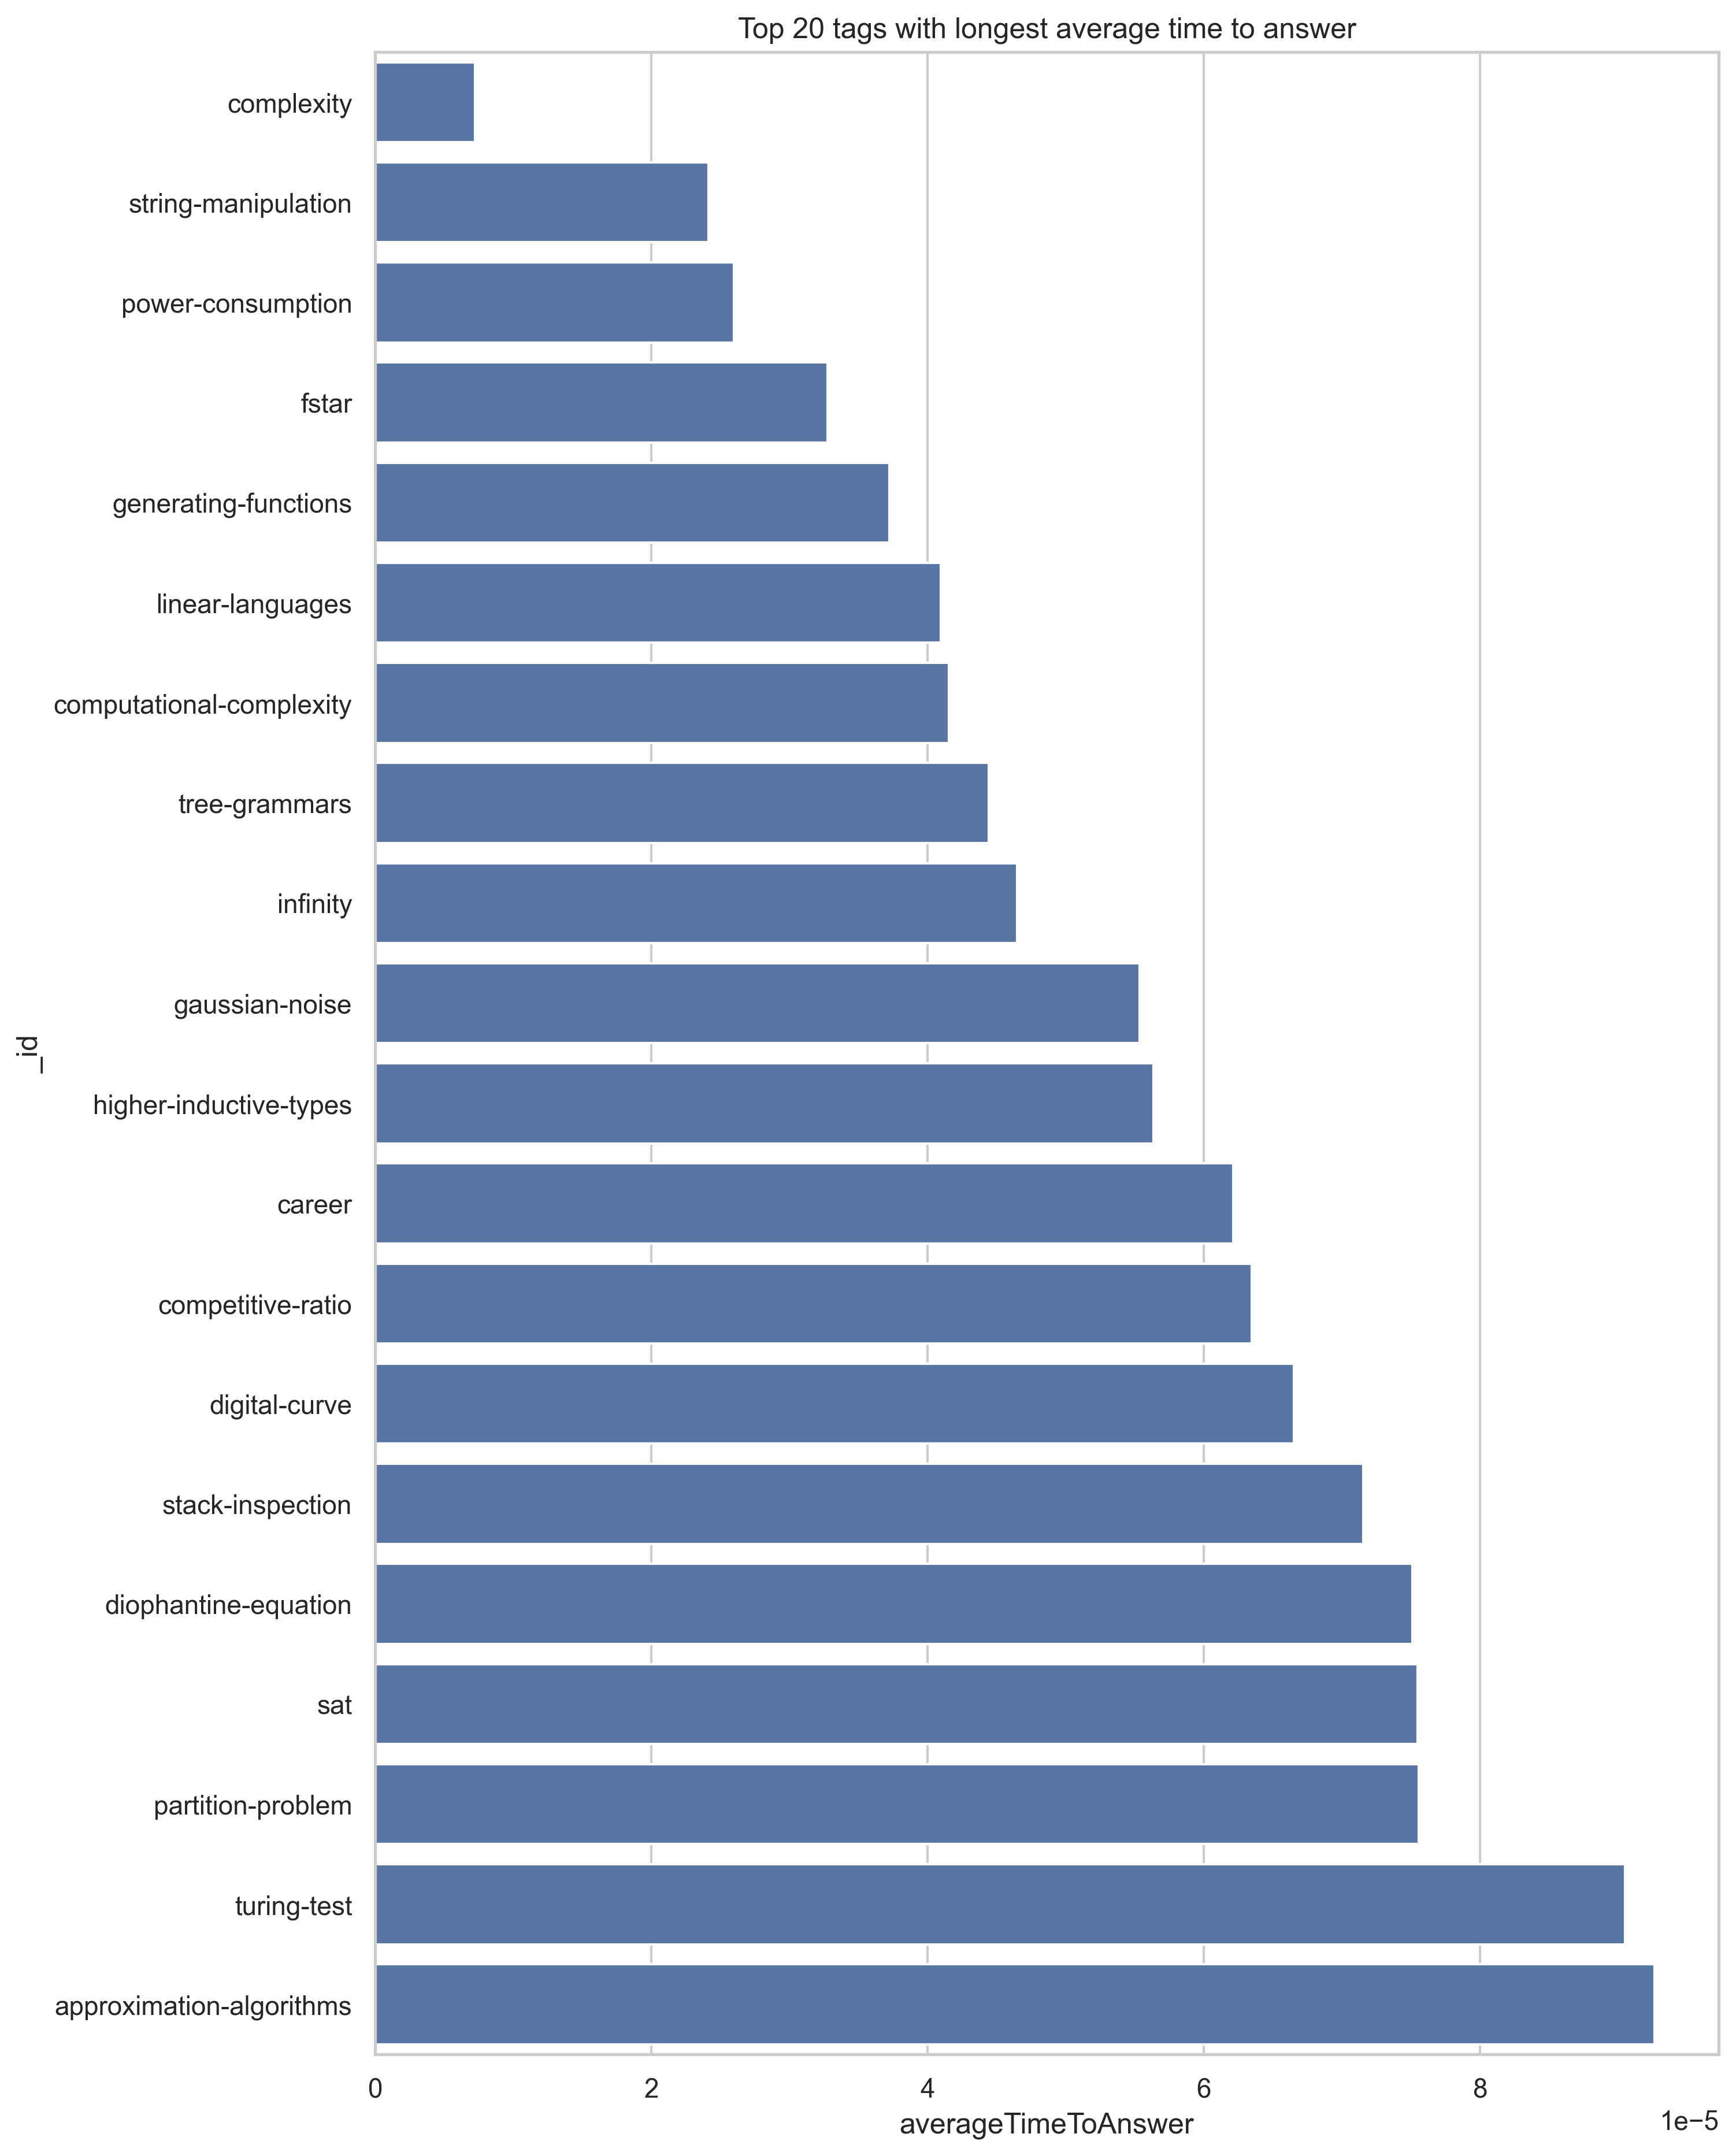

In [23]:
cursor = db.cursor()

SQL1 = """
SELECT
	t1.TagName,
	AVG( t1.Diff ) AS avg_time 
FROM
	(
	SELECT
		TagName,
		p.CreationDate AS QDate,
		a.CreationDate AS ADate,
		TIMESTAMPDIFF( SECOND, p.CreationDate, a.CreationDate ) AS Diff 
	FROM
		posts p
		JOIN post_tags pt ON p.Id = pt.PostId
		JOIN tags t ON pt.TagId = t.Id
		JOIN posts a ON p.AcceptedAnswerId = a.Id 
	WHERE
		p.PostTypeId = 1 
	) AS t1 
GROUP BY
	t1.TagName 
ORDER BY
	avg_time;
"""

cursor.execute(SQL1)
result = cursor.fetchall()

# top 20 tags and bottom 20 tags
sorted_result = sorted(result, key=lambda x: x[1])
top_20 = sorted_result[-20:]
bottom_20 = sorted_result[:20]

# plot use seaborn
# top 20
df = pd.DataFrame(top_20, columns=["_id", "averageTimeToAnswer"])
df['averageTimeToAnswer'] = df['averageTimeToAnswer'].apply(lambda x: float(x) / 3.6e6 / 24)

plt.figure(figsize=(10, 15), dpi=300)  # 修改尺寸以更好地适应横向条形图
sns.barplot(y='_id', x='averageTimeToAnswer', data=df)  # 将条形图转为横向
plt.title('Top 20 tags with longest average time to answer')
plt.show()

# bottom 20
df = pd.DataFrame(bottom_20, columns=["_id", "averageTimeToAnswer"])
df['averageTimeToAnswer'] = df['averageTimeToAnswer'].apply(lambda x: float(x) / 3.6e6 / 24)

plt.figure(figsize=(10, 15), dpi=300)  # 修改尺寸以更好地适应横向条形图
sns.barplot(y='_id', x='averageTimeToAnswer', data=df)  # 将条形图转为横向
plt.title('Top 20 tags with longest average time to answer')
plt.show()

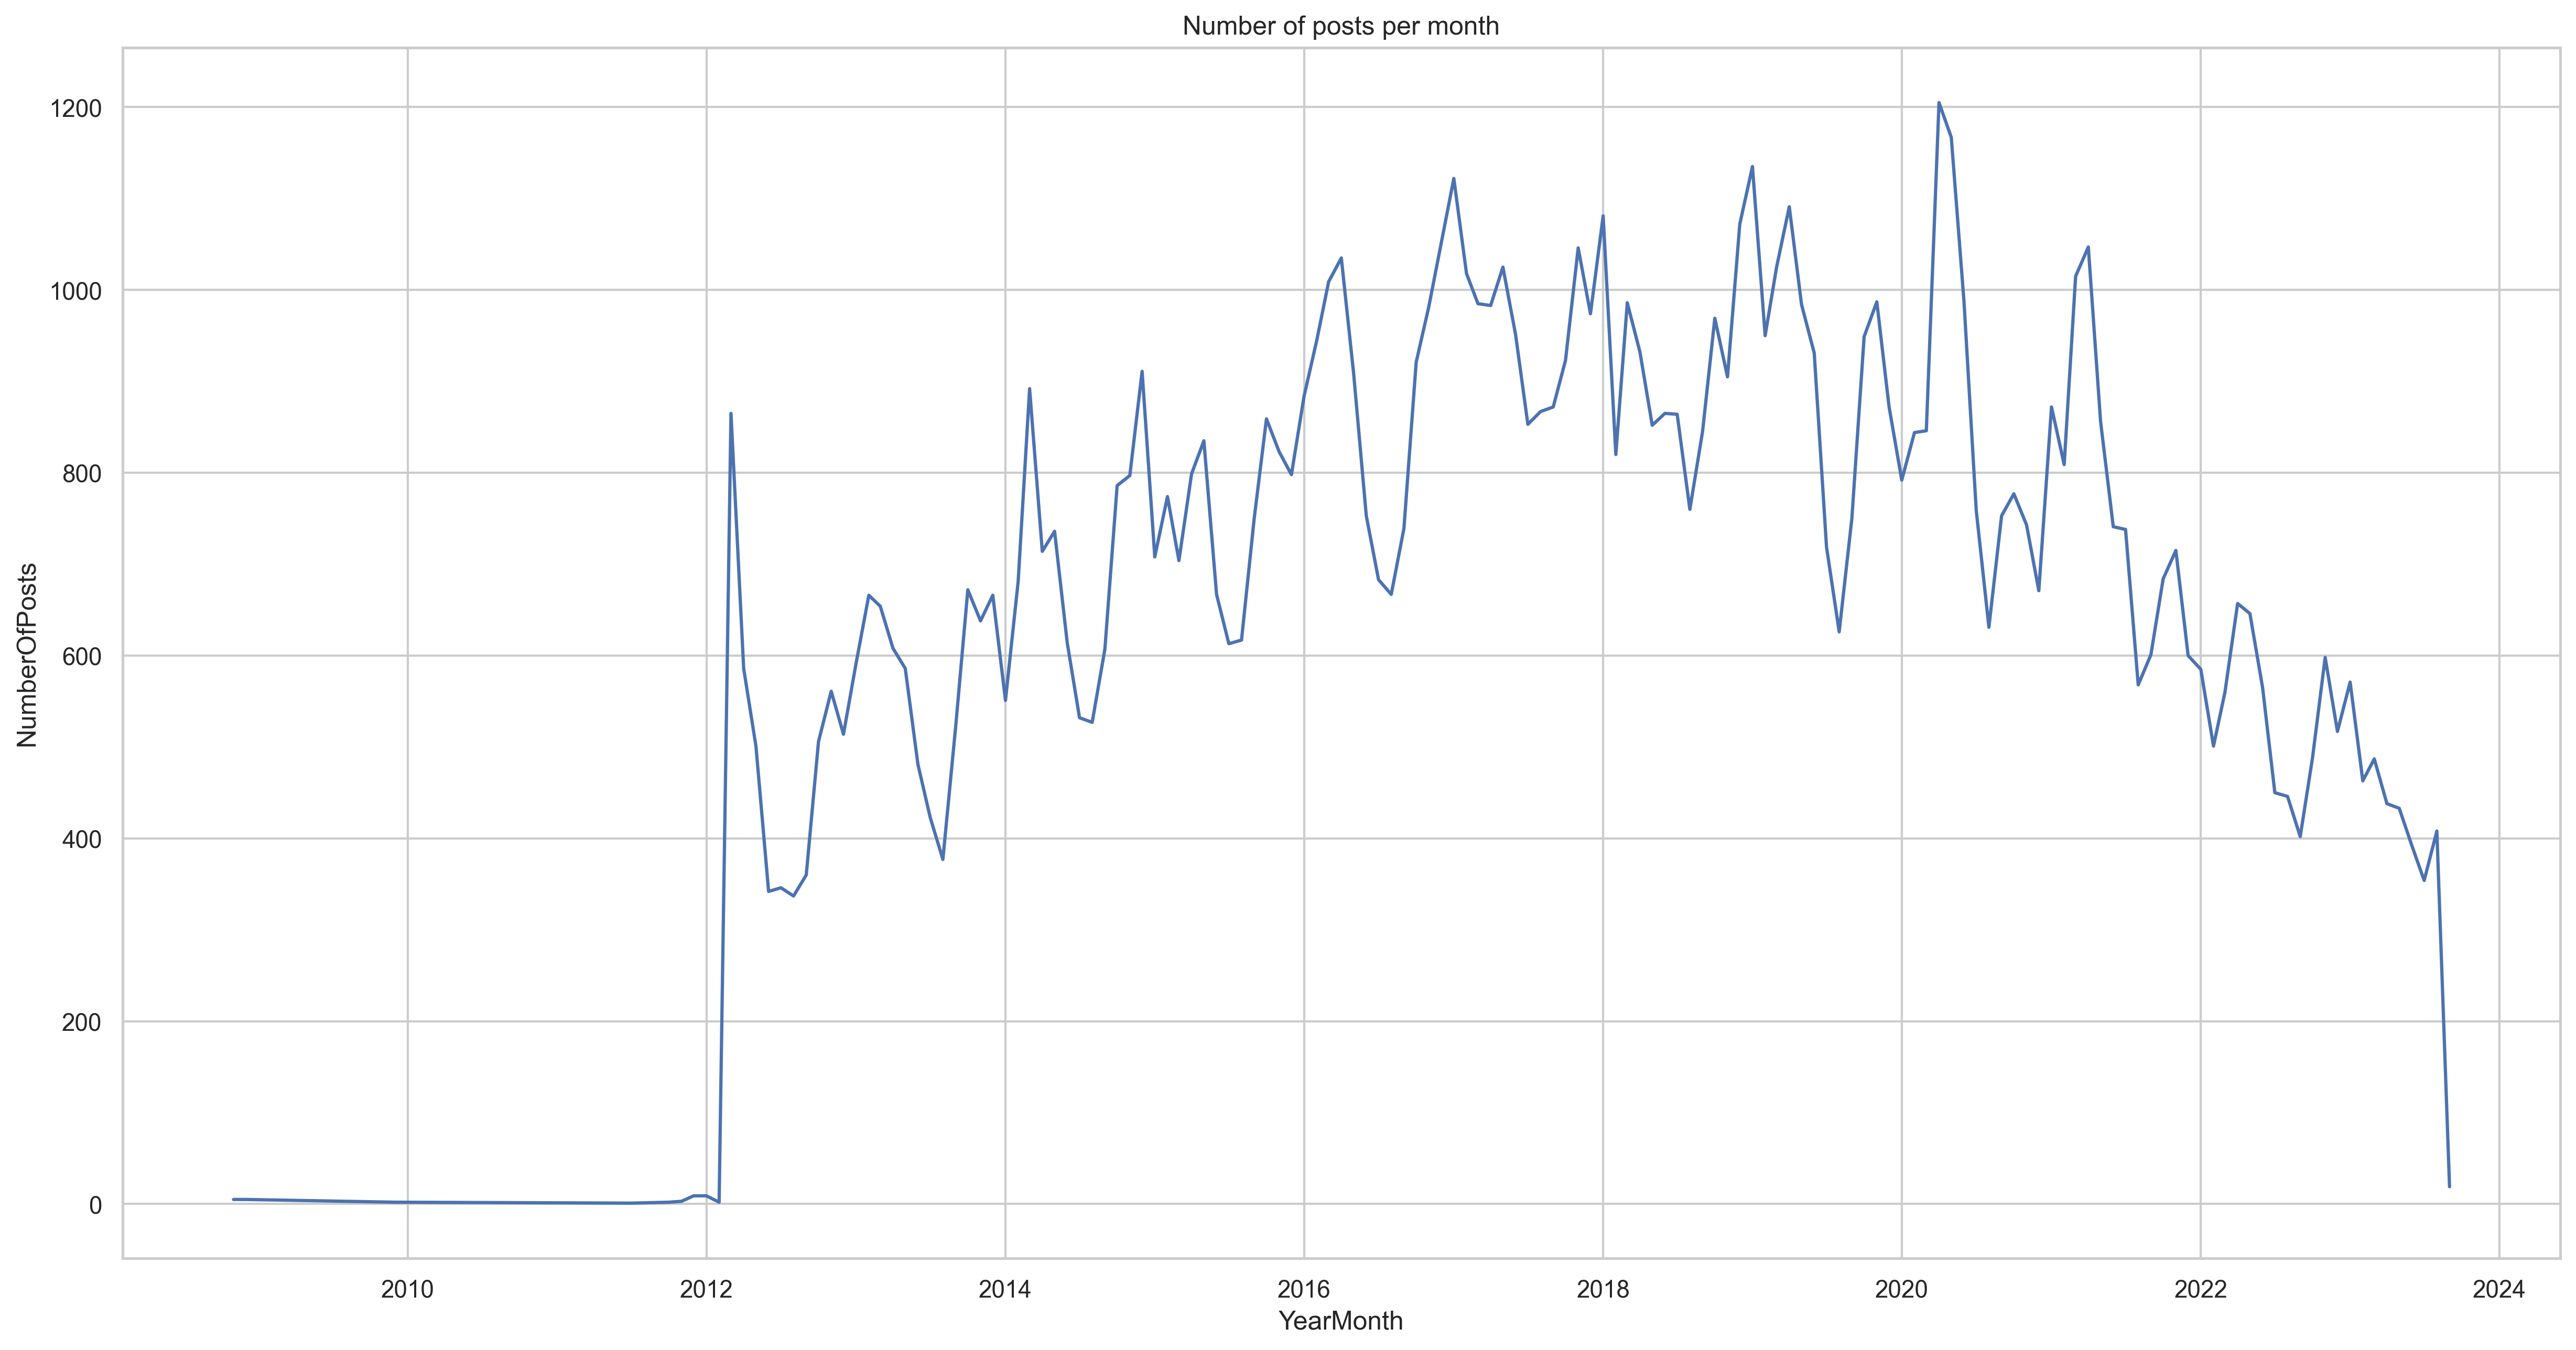

In [24]:

cursor.execute("""SELECT 
    YEAR(CreationDate) AS Year,
    MONTH(CreationDate) AS Month,
    COUNT(*) AS NumberOfPosts
FROM 
    posts
GROUP BY 
    YEAR(CreationDate), MONTH(CreationDate)
ORDER BY 
    Year, Month;""")

result = cursor.fetchall()
df = pd.DataFrame(result, columns=["Year", "Month", "NumberOfPosts"])
df["Month"] = df["Month"].apply(lambda x: str(x).zfill(2))
df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str)
df["YearMonth"] = pd.to_datetime(df["YearMonth"])
df["NumberOfPosts"] = df["NumberOfPosts"].astype(int)

plt.figure(figsize=(20, 10), dpi=300)
sns.lineplot(x="YearMonth", y="NumberOfPosts", data=df)
plt.title("Number of posts per month")
plt.show()


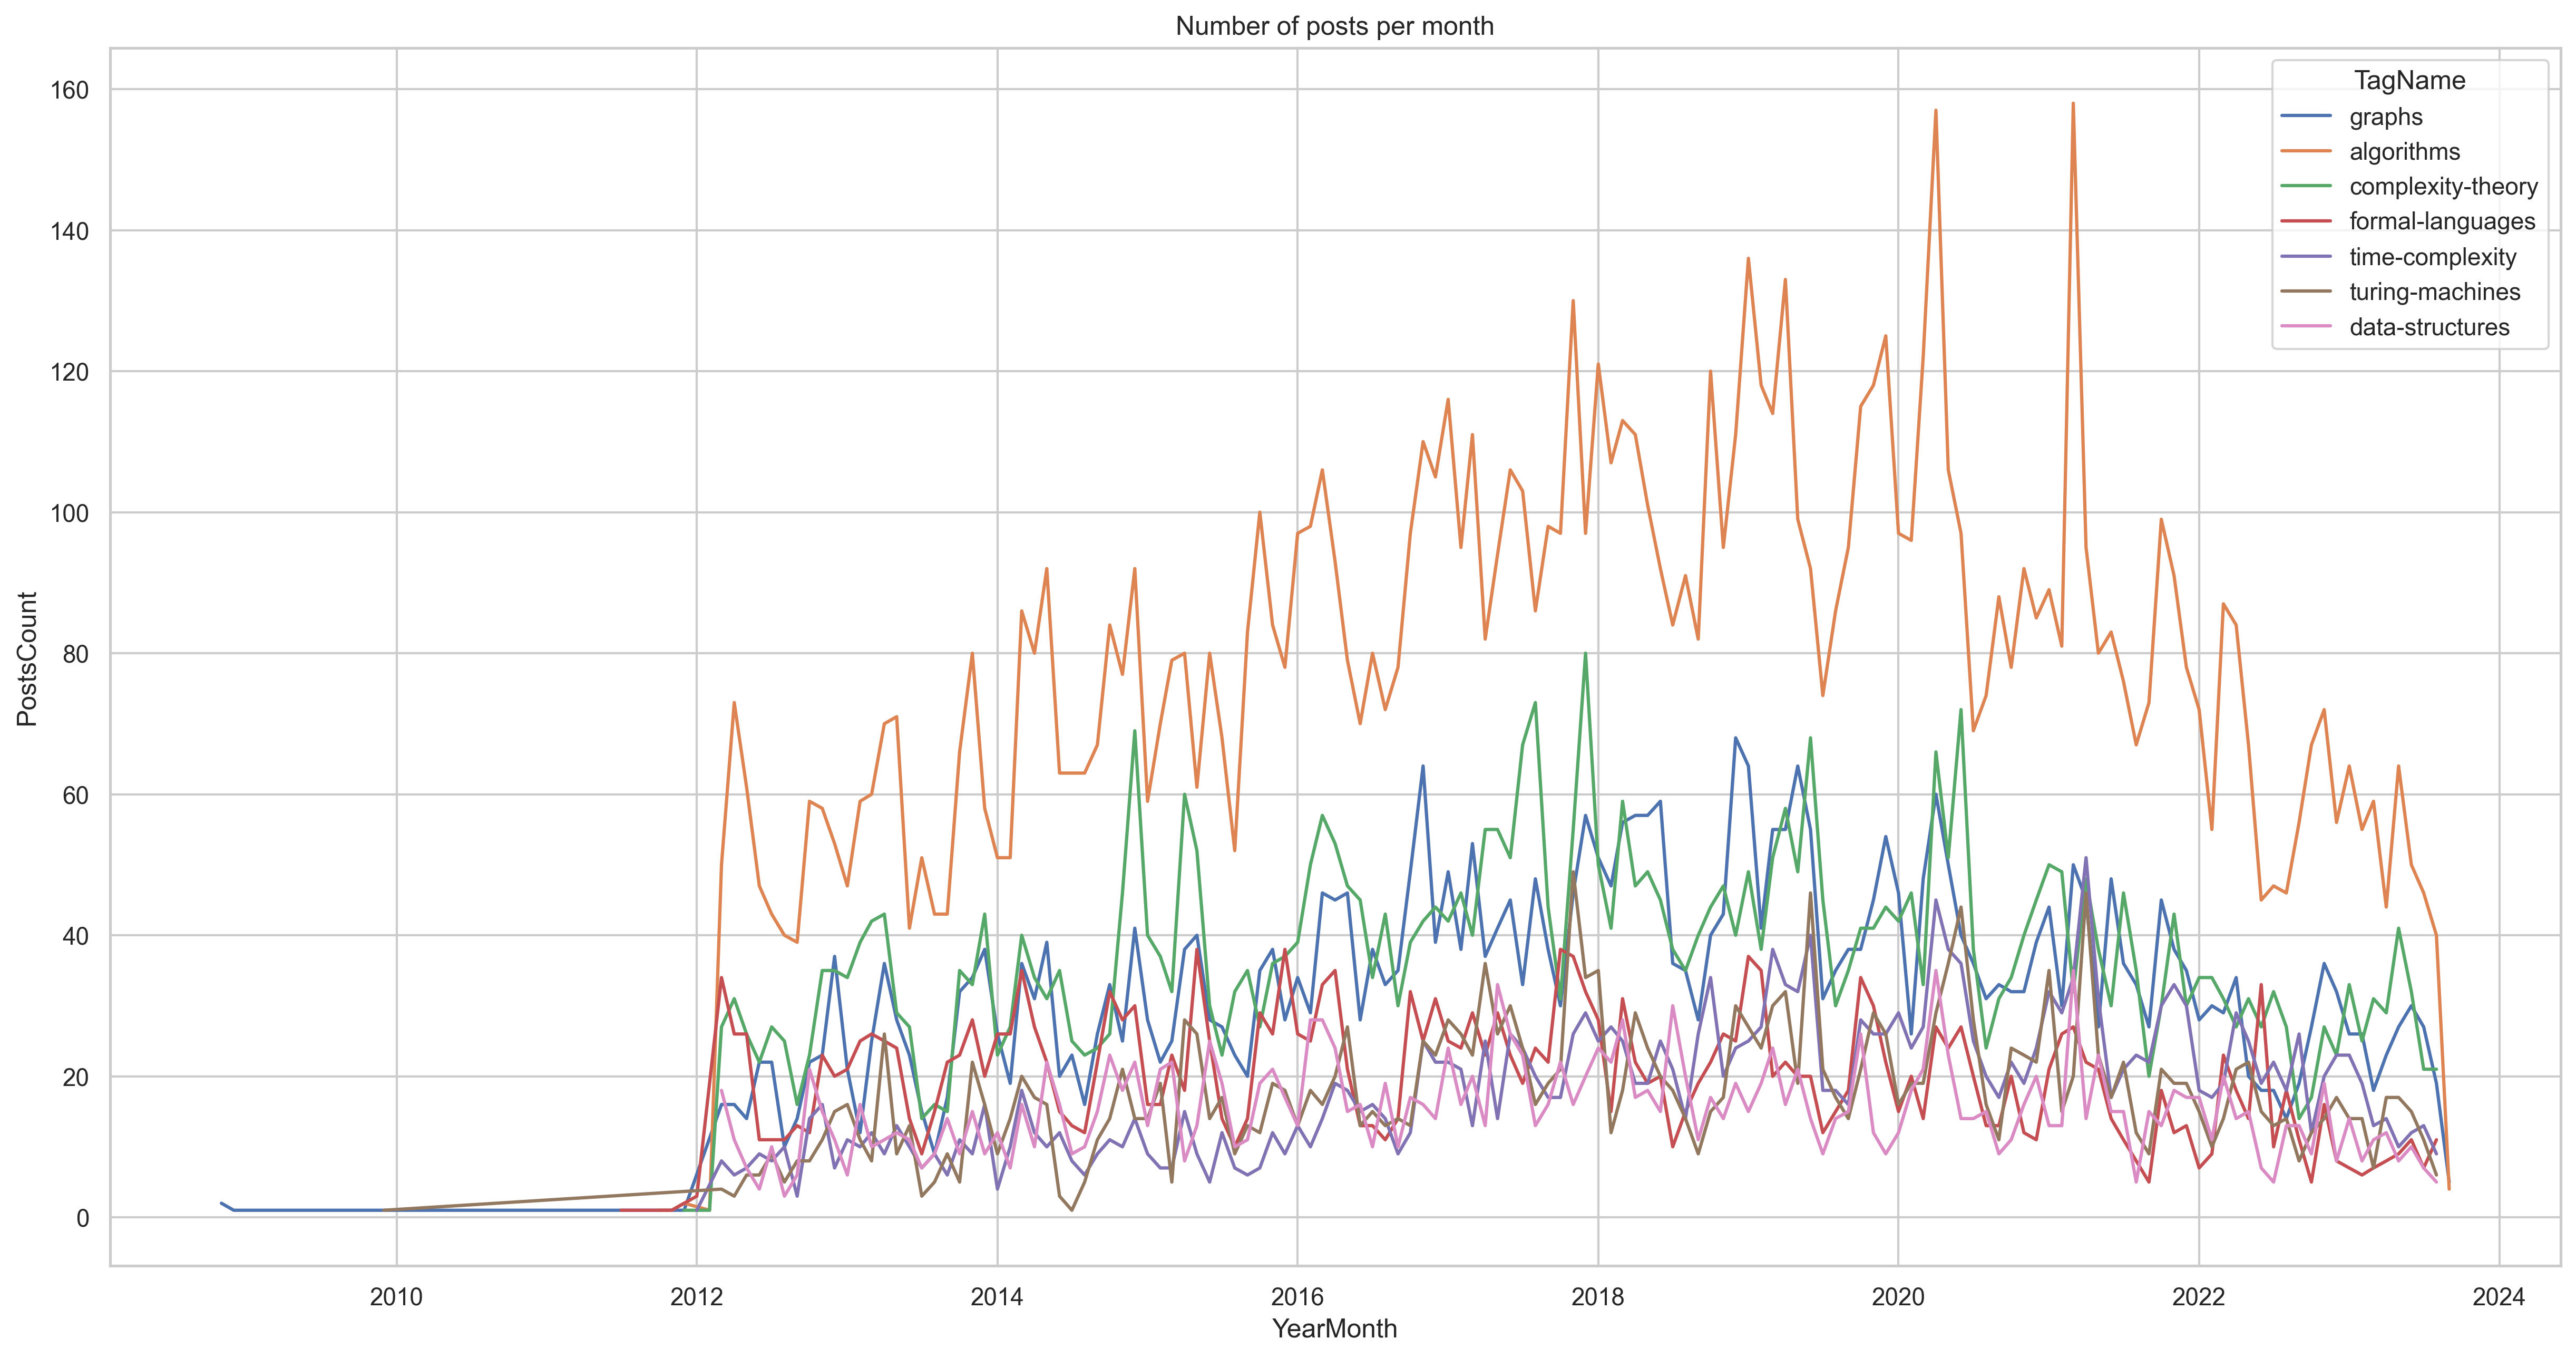

In [33]:
cursor.execute("""SELECT 
    YEAR(p.CreationDate) as Year,
    MONTH(p.CreationDate) as Month,
    t.TagName,
    COUNT(*) as PostsCount
FROM 
    posts p
JOIN 
    post_tags pt ON p.Id = pt.PostId
JOIN 
    tags t ON pt.TagId = t.Id
-- WHERE 
--     p.CreationDate >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR)
GROUP BY 
    YEAR(p.CreationDate), MONTH(p.CreationDate), t.TagName
ORDER BY 
    Year DESC, Month DESC, PostsCount DESC;""")

result = cursor.fetchall()
df = pd.DataFrame(result, columns=["Year", "Month", "TagName", "PostsCount"])
df["Month"] = df["Month"].apply(lambda x: str(x).zfill(2))
df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str)
df["YearMonth"] = pd.to_datetime(df["YearMonth"])
df["PostsCount"] = df["PostsCount"].astype(int)

# rank top 10 tags all time to show trend
top_10 = df.groupby("TagName")["PostsCount"].sum().sort_values(ascending=False).head(7).index
df = df[df["TagName"].isin(top_10)]

plt.figure(figsize=(20, 10), dpi=300)
sns.lineplot(x="YearMonth", y="PostsCount", hue="TagName", data=df)
plt.title("Number of posts per month")
plt.show()